In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nmf_son.base import nmf_son
from nmf_son.utils import load_results
from sklearn.decomposition import NMF

np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def plot_scores(fscores, gscores, lambda_vals, plot_title=None, filename=None):
    fscores = fscores[1:]
    gscores = gscores[1:]
    lambda_vals = lambda_vals[1:]
    total_score = fscores + lambda_vals * gscores
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)

    axs[0].set_yscale('log')
    axs[0].plot(total_score, color='black', linewidth=3, label='$F(W, H)$')
    axs[0].plot(fscores, color='cyan', linewidth=1.5, label='$f(W, H)$')
    axs[0].plot(gscores, color='yellow', linewidth=1.5, label='$g(W)$')
    axs[0].set_xlabel('Iterations')
    axs[0].legend()

    fscores -= min(fscores)
    gscores -= min(gscores)
    total_score -= min(total_score)

    axs[1].set_yscale('log')
    axs[1].plot(total_score, color='black', linewidth=3, label='$F(W, H) - min(F(W, H))$')
    axs[1].plot(fscores, color='cyan', linewidth=1.5, label='$f(W, H) - min(f(W, H))$')
    axs[1].plot(gscores, color='yellow', linewidth=1.5, label='$g(W) - min(g(W))$')
    axs[1].set_xlabel('Iterations')
    axs[1].legend()

    if filename:
        fig.savefig(filename)


def plot_seperate_H(H, img_size, figsize, fontsize, normalize_row=False, split=False, filename=None):
    rank = H.shape[0]
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    if split:
        half_rank = int(rank / 2)
        fig, axs = plt.subplots(2, half_rank, figsize=figsize)
        i, j, cnt = 0, 0, 0
        while cnt < rank:
            img = axs[i, j].imshow(H3d[cnt, :, :], cmap='gray')
            axs[i, j].set_title(f'$h^{cnt + 1}$', fontsize=fontsize)
            axs[i, j].axis('off')
            divider = make_axes_locatable(axs[i, j])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')



            j += 1
            if cnt + 1 == half_rank:
                i = 1
                j = 0
            cnt += 1
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        cnt = 0
        while cnt < rank:
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
            axs[cnt].set_title(f'$h^{cnt + 1}$', fontsize=fontsize)
            axs[cnt].axis('off')
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')

            cnt += 1
    # plt.tight_layout()
    if filename:
        plt.savefig(filename)


def plot_combined_H(H, img_size, figsize, normalize_row=False, split=False, filename=None):
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    if split:
        half_rank = int(H.shape[0] / 2)
        large_mat = np.vstack([np.hstack(H3d[: half_rank, :, :]), np.hstack(H3d[half_rank: , :, :])])
    else:
        large_mat = np.hstack(H3d)
    plt.figure(figsize=figsize)
    ax = plt.axes()
    im = plt.imshow(large_mat, cmap='gray')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    plt.colorbar(im, cax=cax)

    if filename:
        plt.savefig(filename)


def plot_W_mats(W, figsize, fontsize, split=False, filename=None, scale_y=False, log_scale=False, plot_title=None):
    rank = W.shape[1]
    wmin = np.min(W)
    wmax = np.max(W)

    if split:
        half_rank = int(rank / 2)
        fig, axs = plt.subplots(2, half_rank, figsize=figsize)
        i, j, cnt = 0, 0, 0
        while cnt < rank:
            axs[i, j].plot(W[:, cnt], linewidth=3)
            if scale_y:
                axs[i, j].set_ylim([min(0, wmin), wmax])
            if log_scale:
                axs[i, j].set_yscale('log')
            axs[i, j].set_title(f'$w_{cnt + 1}$', fontsize=fontsize)
            axs[i, j].set_xlabel(f'Bands')
            axs[i, j].set_ylabel(f'Reflectance')
            j += 1
            if cnt + 1 == half_rank:
                i = 1
                j = 0
            cnt += 1
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        cnt = 0
        while cnt < rank:
            axs[cnt].plot(W[:, cnt], linewidth=3)
            if scale_y:
                axs[cnt].set_ylim([min(0, wmin), wmax])
            if log_scale:
                axs[cnt].set_yscale('log')
            axs[cnt].set_title(f'$w_{cnt + 1}$', fontsize=fontsize)
            axs[cnt].set_xlabel(f'Bands')
            axs[cnt].set_ylabel(f'Reflectance')

            cnt += 1
    plt.tight_layout()

    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)

In [3]:
max_iter = 3000

## Urban Small

In [4]:
X = np.load('../datasets/urban_small.npz')['X']
m, n = X.shape
rank = 6
true_rank = 2
img_size = (20, 10)
data = np.load(f'../saved_models/urban_small_r{rank}_ini.npz')
ini_W = data['W']
ini_H = data['H']
save_filepath = '../saved_models/urban_small_tuning/r{}_l{}.npz'

reg_vals = [1e-7, 1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4.5, 5, 8, 10, 20, 50, 100, 1000, 10000]

In [5]:
# for reg_val in reg_vals:
#     Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(X, ini_W.copy(), ini_H.copy(), _lambda=reg_val, itermax=max_iter)
#     with open(save_filepath.format(rank, reg_val), 'wb') as fout:
#         np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)
#         print(reg_val, 'done')

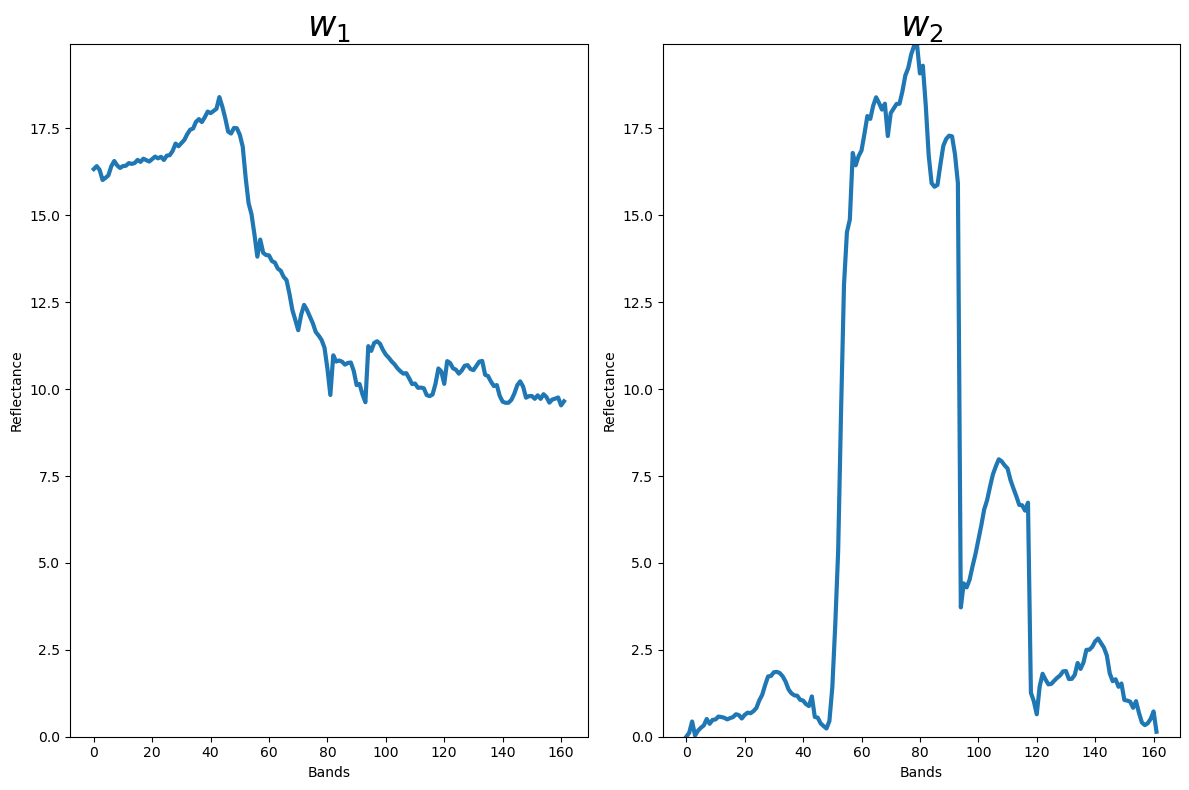

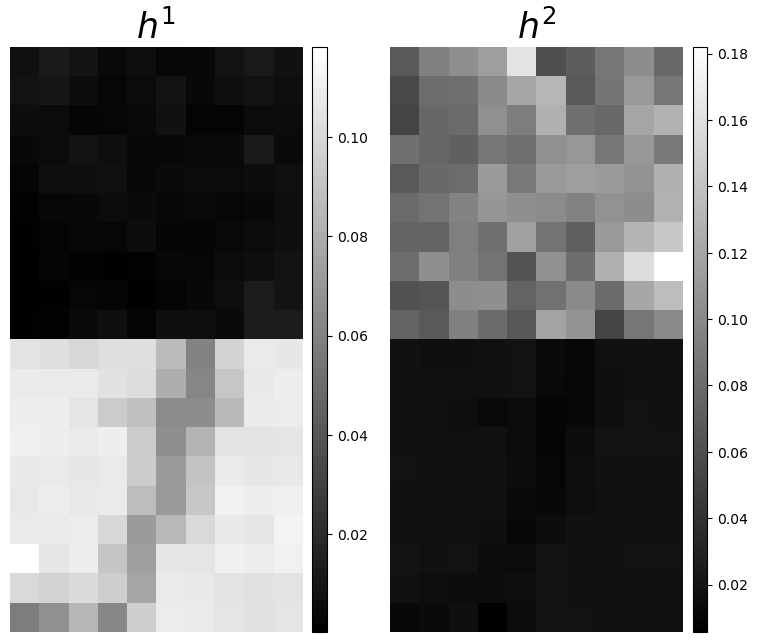

In [10]:
# model = NMF(n_components=true_rank, init='random', random_state=42, tol=1e-5, max_iter=3000)
# vanillaW = model.fit_transform(X=X)
# vanillaH = model.components_
plot_W_mats(vanillaW, figsize=(12, 8), fontsize=25, scale_y=True, filename=f'../images_plots/small_urban_w_r{true_rank}_vanilla.png')
plot_seperate_H(vanillaH, img_size, figsize=(9, 8), fontsize=25, normalize_row=True, filename=f'../images_plots/small_urban_h_r{true_rank}_vanilla.png')

/Users/waqas/opt/anaconda3/envs/seminmf/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


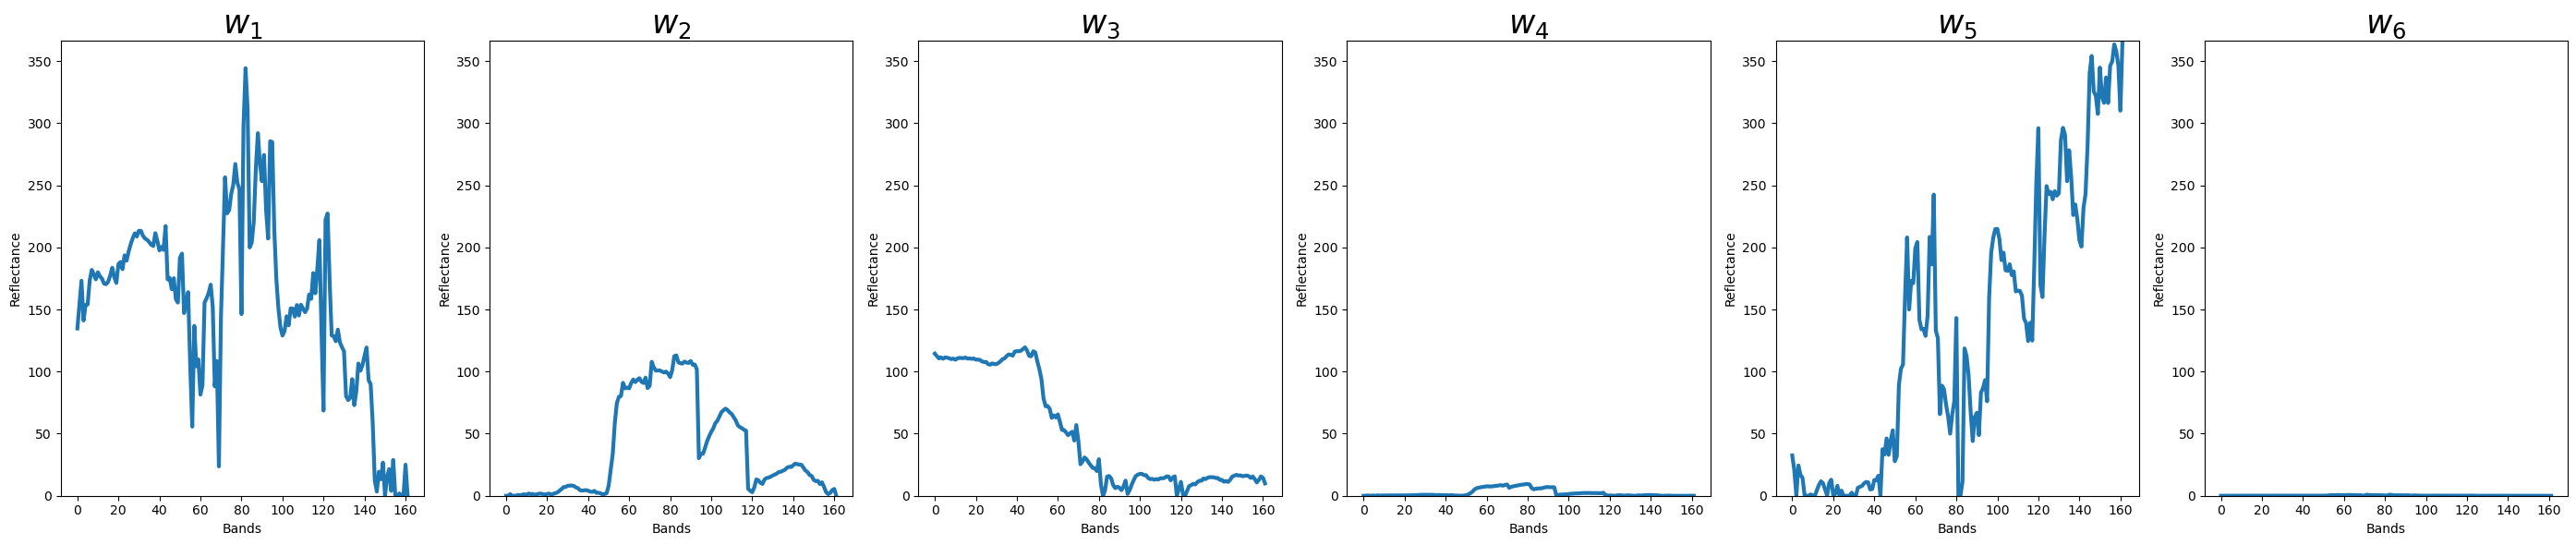

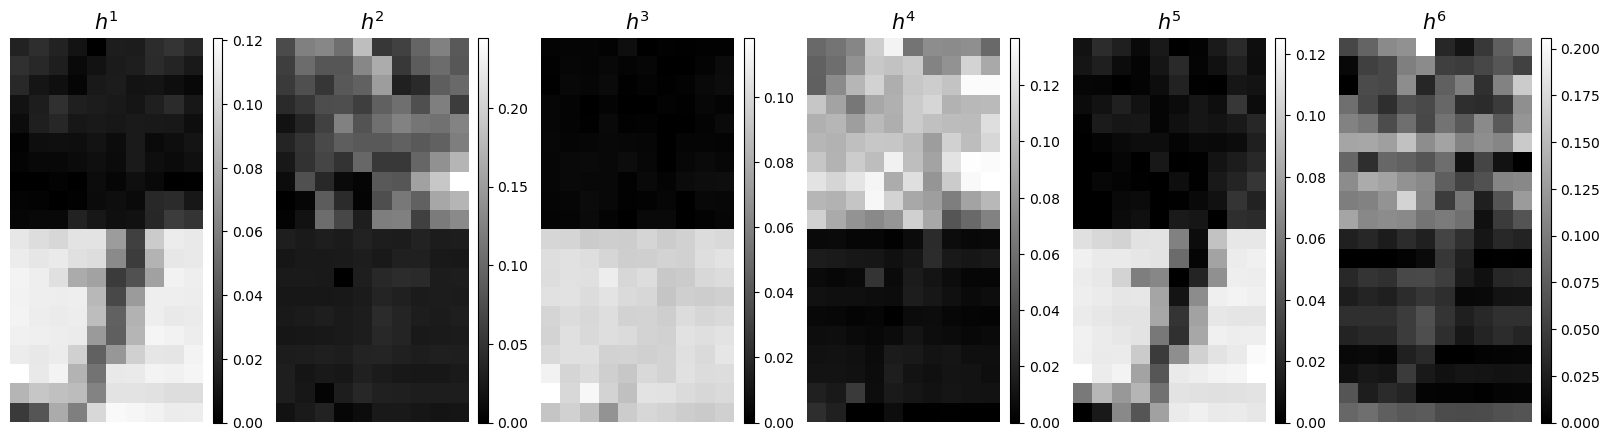

In [12]:
model = NMF(n_components=rank, init='custom', random_state=42, tol=1e-5, max_iter=3000)
vanillaW2 = model.fit_transform(X=X, W=ini_W.copy(), H=ini_H.copy())
vanillaH2 = model.components_
plot_W_mats(vanillaW2, figsize=(28, 6), fontsize=25, scale_y=True, filename=f'../images_plots/small_urban_w_r{rank}_vanilla.png')
plot_seperate_H(vanillaH2, img_size, figsize=(20, 5), fontsize=15, normalize_row=True, filename=f'../images_plots/small_urban_h_r{rank}_vanilla.png')

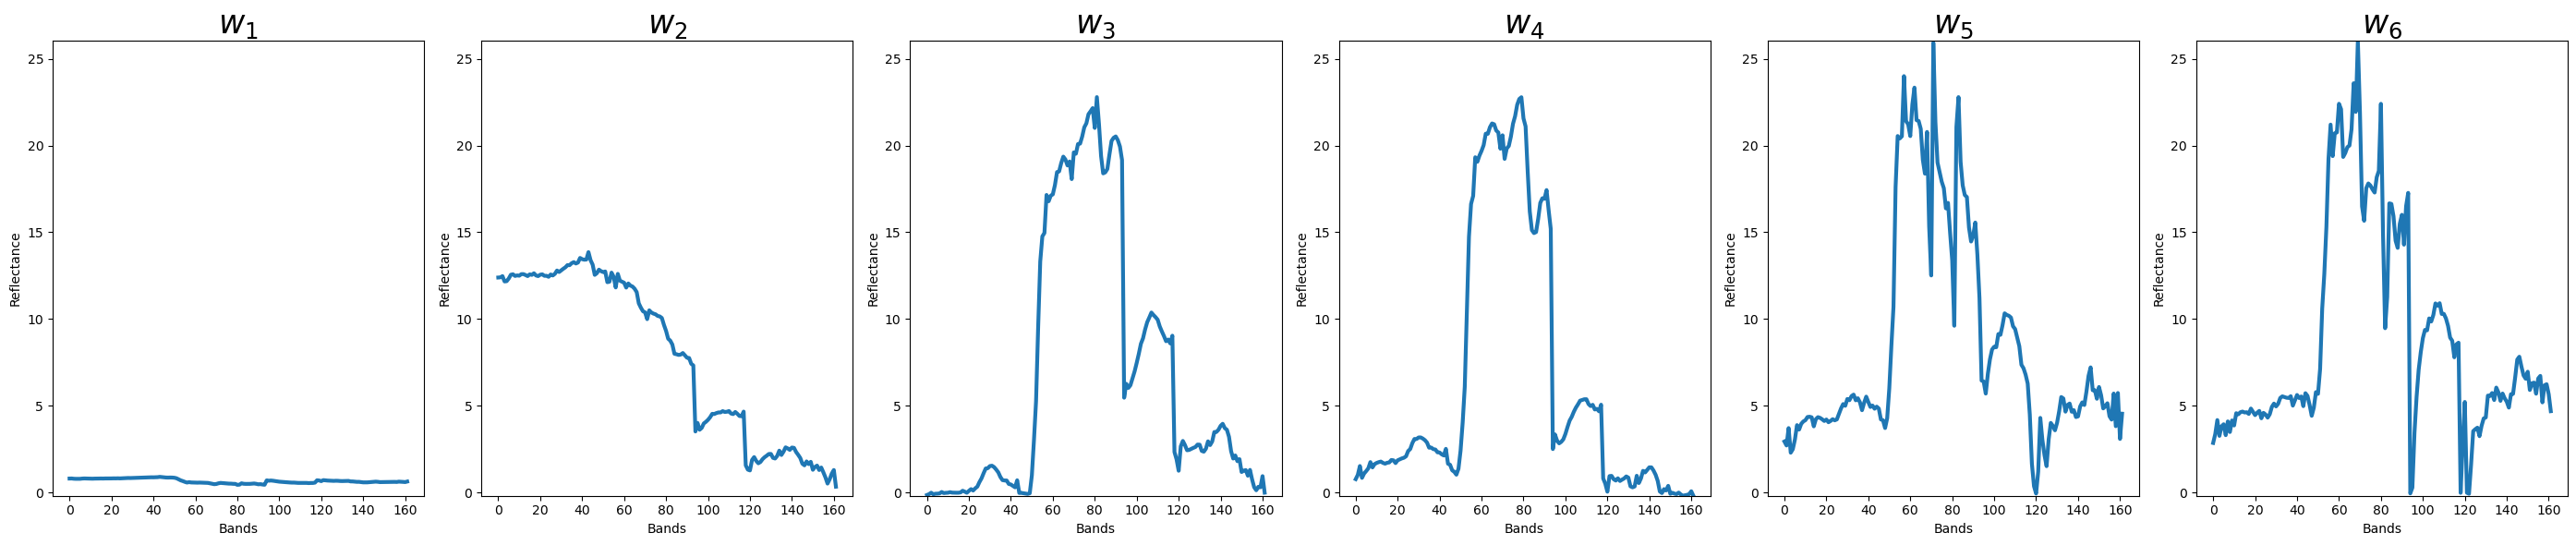

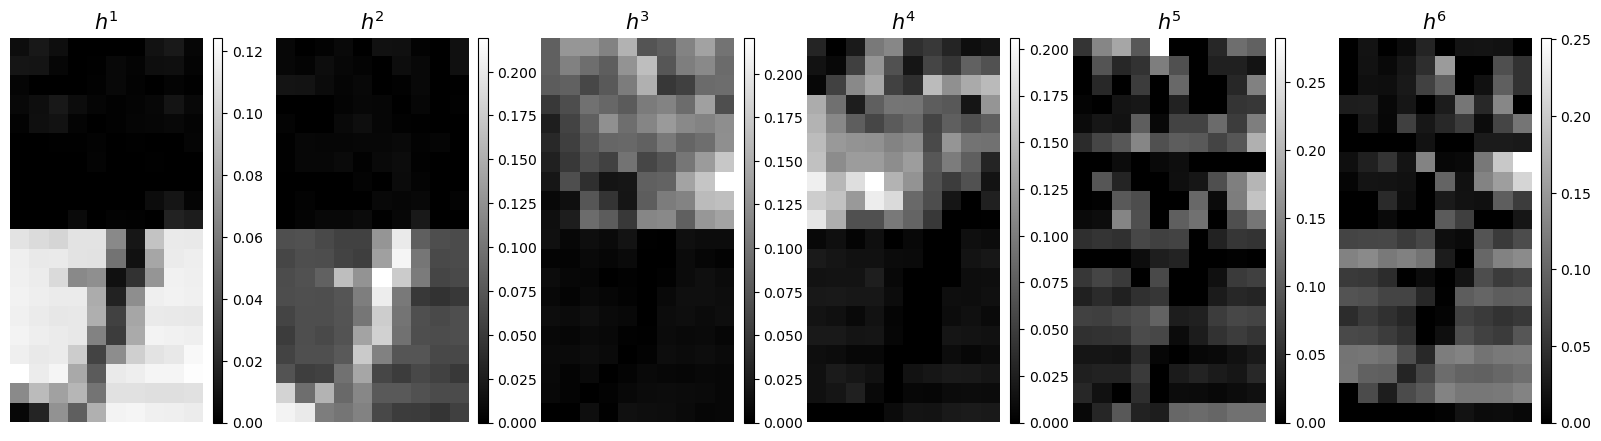

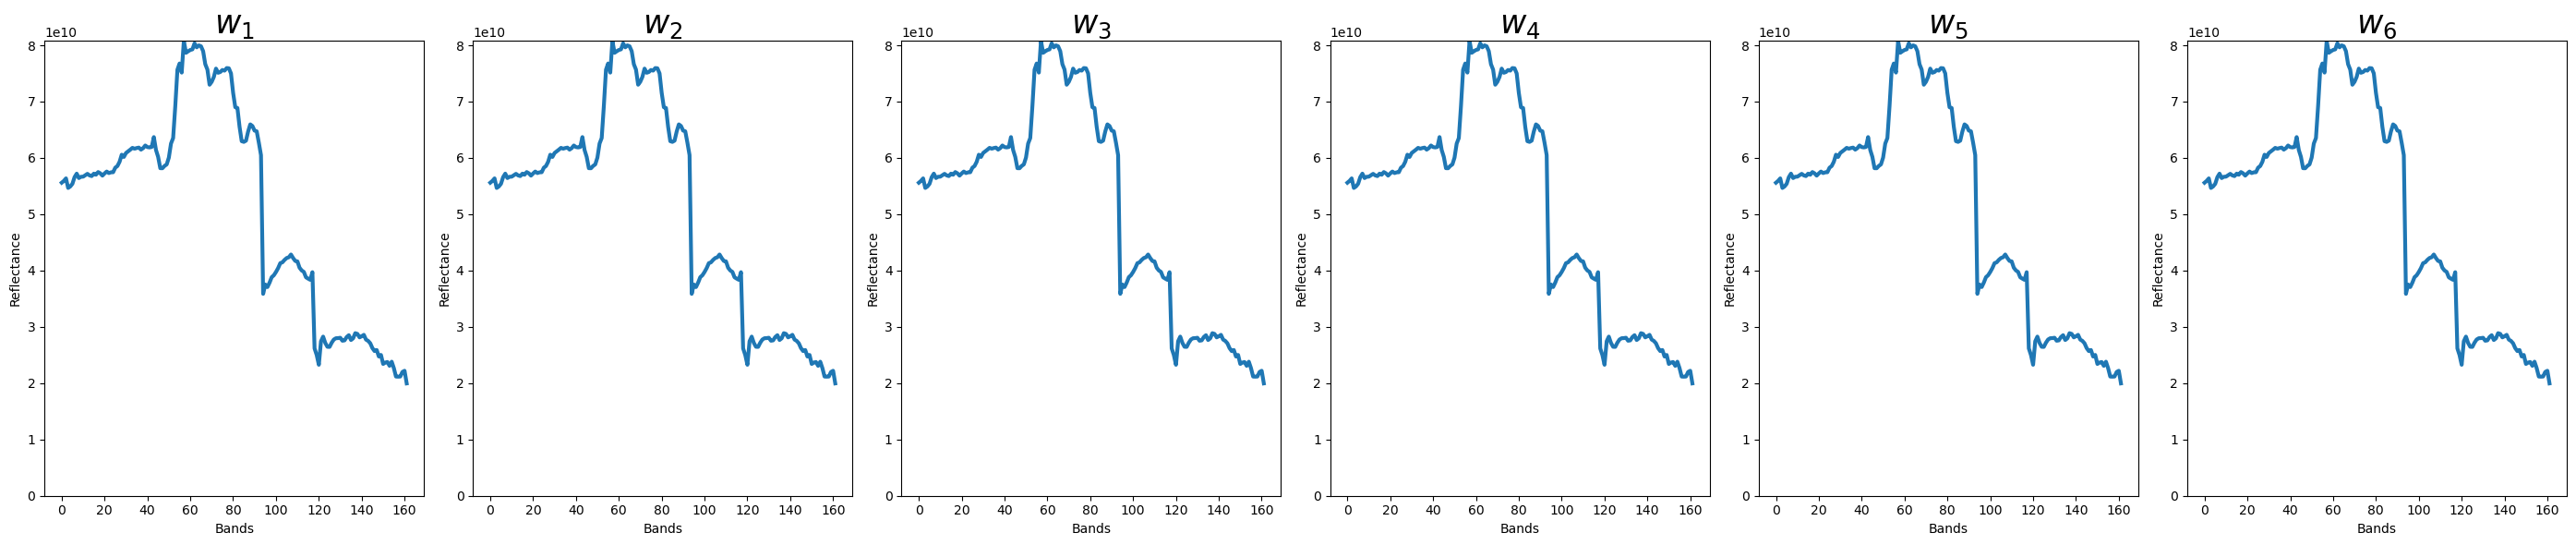

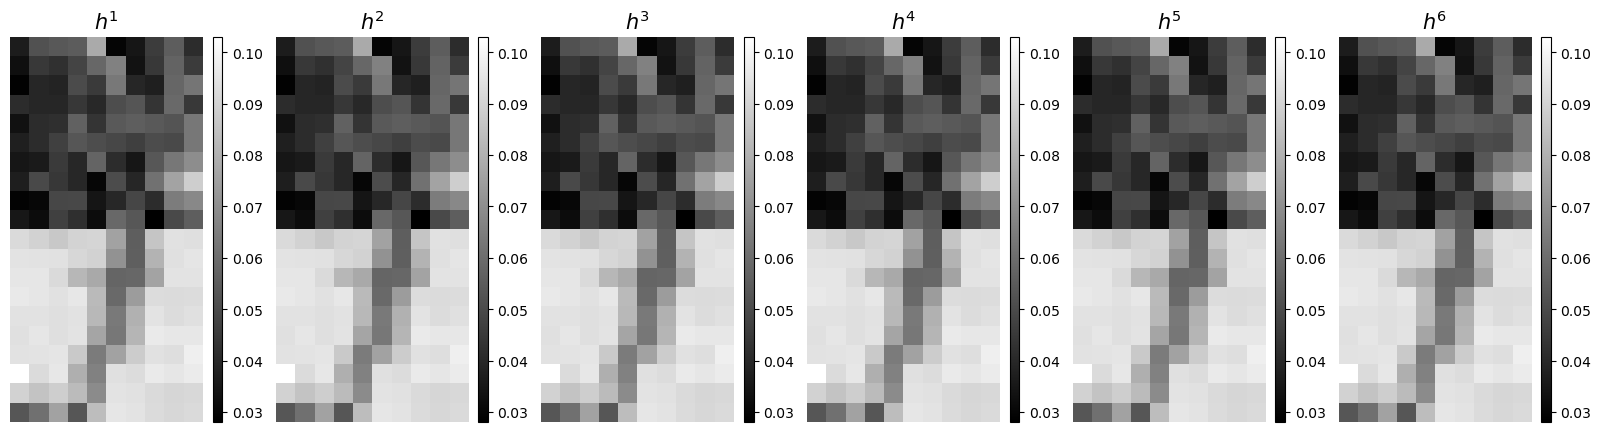

In [14]:
for reg_val in [3, 50]:
    Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg_val))
    # plot_scores(fscores, gscores, lambda_vals, f'$\lambda = {reg_val}$')
    plot_W_mats(Wl, figsize=(28, 6), fontsize=25, scale_y=True, filename=f'../images_plots/small_urban_w_r{rank}_l{reg_val}.png')
    plot_seperate_H(Hl, img_size, figsize=(20, 5), fontsize=15, normalize_row=True, filename=f'../images_plots/small_urban_h_r{rank}_l{reg_val}.png')

## Jasper

In [15]:
X = np.load('../datasets/jasper_full.npz')['X']
m, n = X.shape

true_rank = 4
rank = 8
img_size = (100, 100)
data = np.load(f'../saved_models/jasper_full_r{rank}_ini.npz')
ini_W = data['W']
ini_H = data['H']
save_filepath = '../saved_models/jasper_tuning/r{}_l{}.npz'
img_filepath = '../images_plots/jasper_{}_r{}_{}.png'

reg_vals = [1e-8, 1e-7, 1e-6, 1e-5, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8, 10, 15, 20, 25, 40, 45, 50, 100, 1000]
# reg_vals = [0.005, 0.05, 0.2, 0.8, 8, 15, 25, 40, 45]
reg_vals = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8]


SCALE_Y = True
NORM_H = True
LOG_SCALE = False

In [16]:
# m, n = X.shape
# rank = 10
# ini_W = np.random.rand(m, rank)
# ini_H = np.random.rand(rank, n)
# reg_vals = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# reg_vals = [0.2, 0.5, 0.8, 1.5, 2, 5, 8, 20, 30, 40]

/Users/waqas/opt/anaconda3/envs/seminmf/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


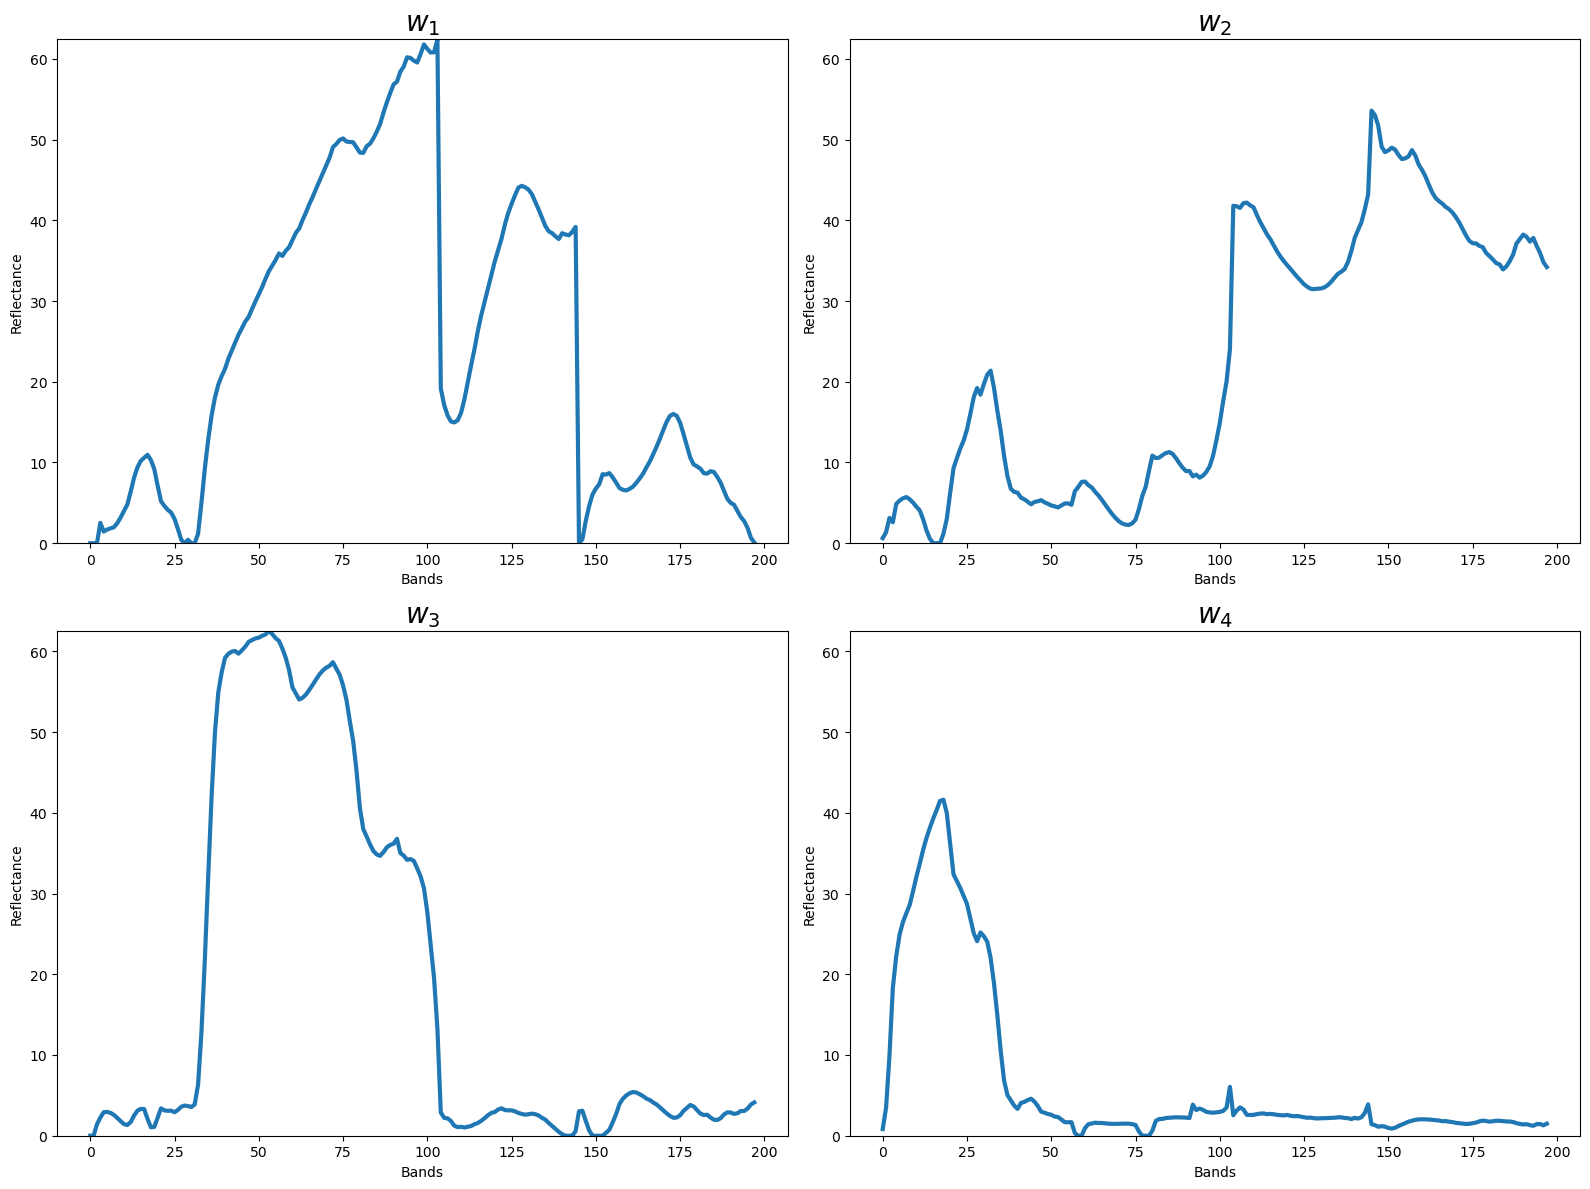

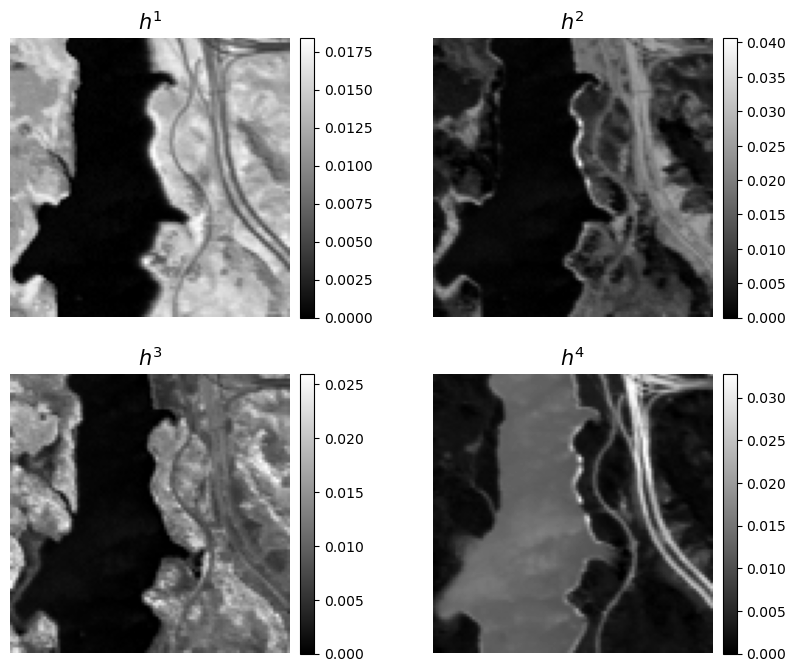

In [18]:
# model = NMF(n_components=true_rank, init='random', random_state=42, tol=1e-5, max_iter=3000)
# vanillaW = model.fit_transform(X=X)
# vanillaH = model.components_
plot_W_mats(vanillaW, figsize=(16, 12), fontsize=20, split=True, scale_y=SCALE_Y, log_scale=LOG_SCALE, filename=img_filepath.format('w', true_rank, 'vanilla'))
plot_seperate_H(vanillaH, img_size, figsize=(10, 8), fontsize=15, split=True, normalize_row=NORM_H, filename=img_filepath.format('h', true_rank, 'vanilla'))

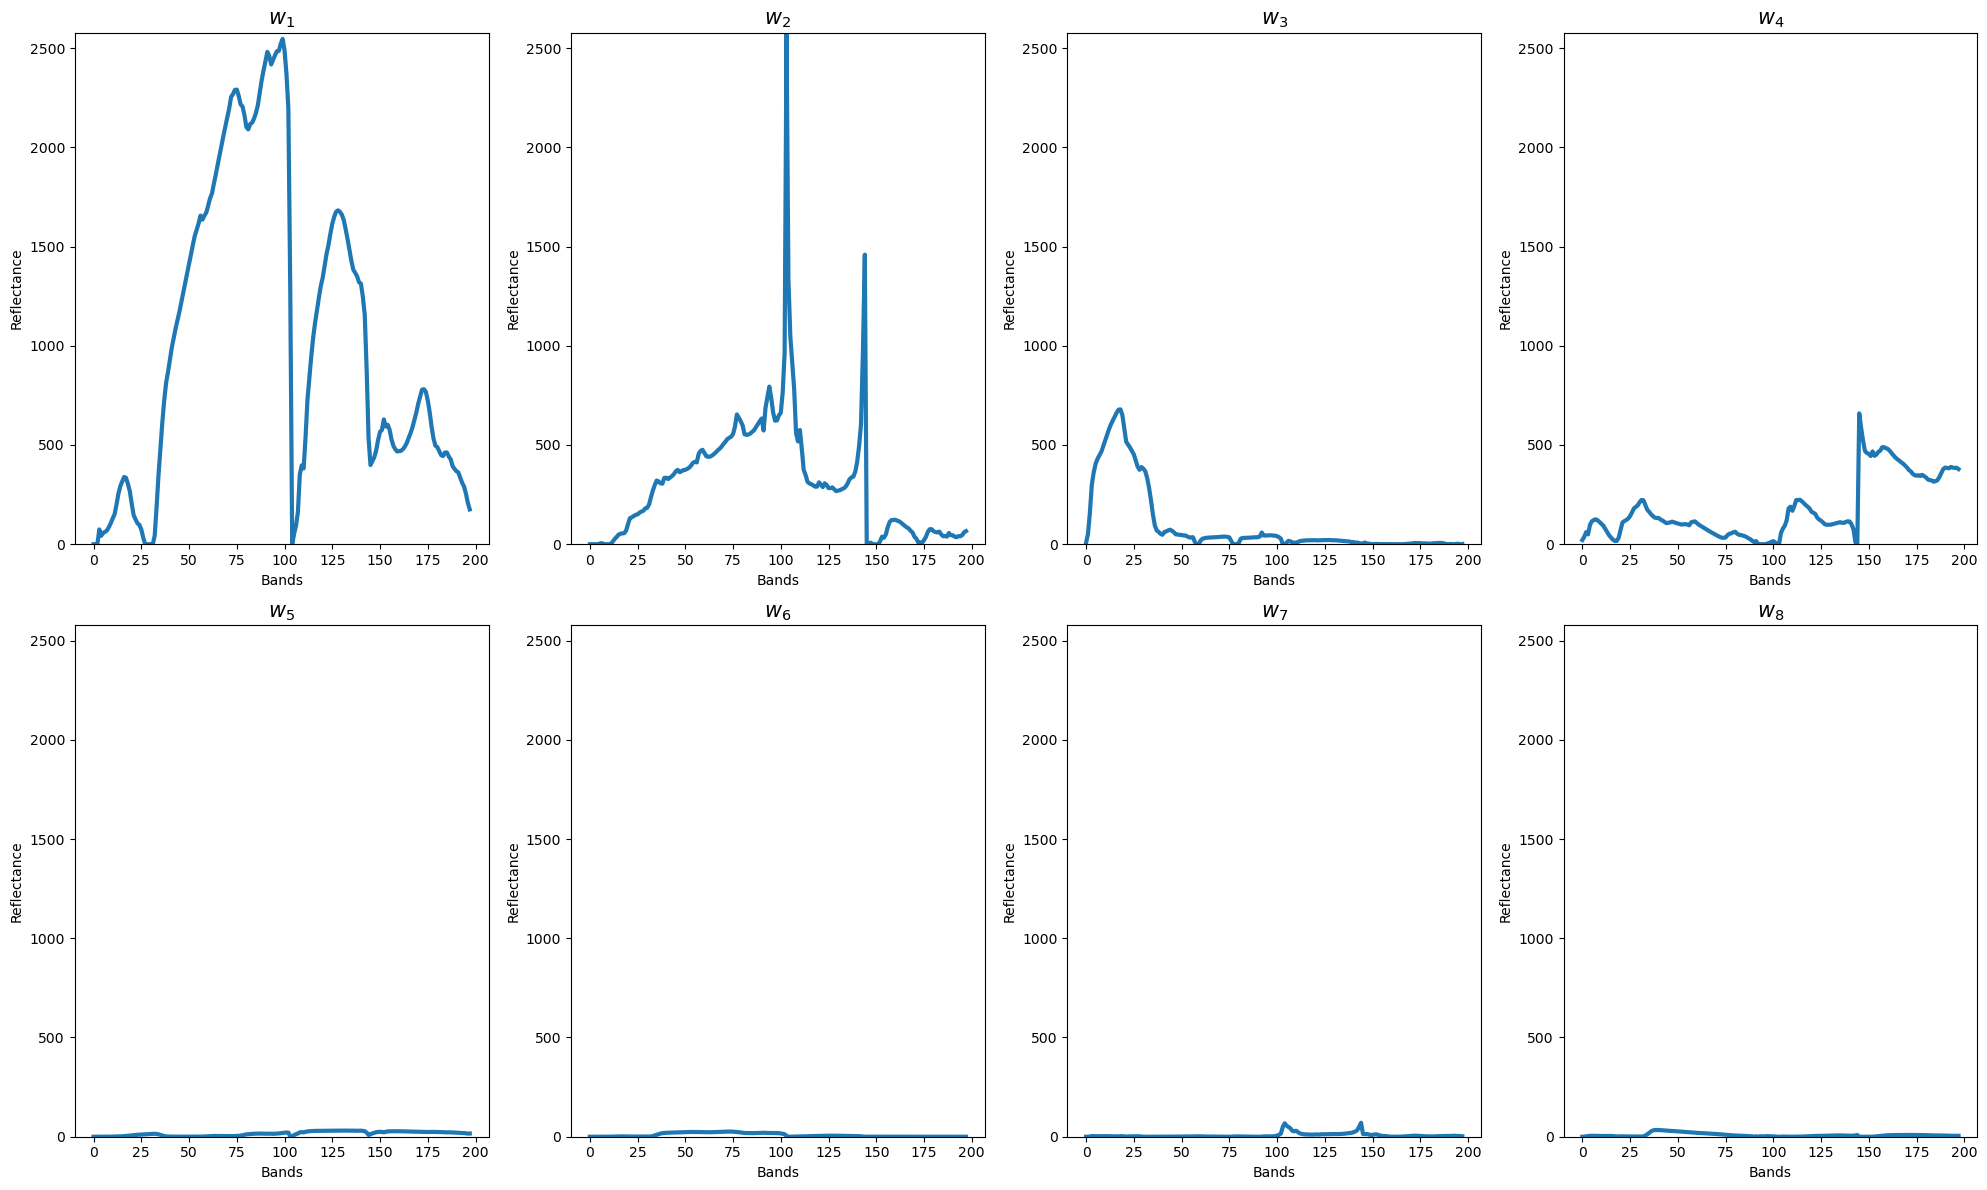

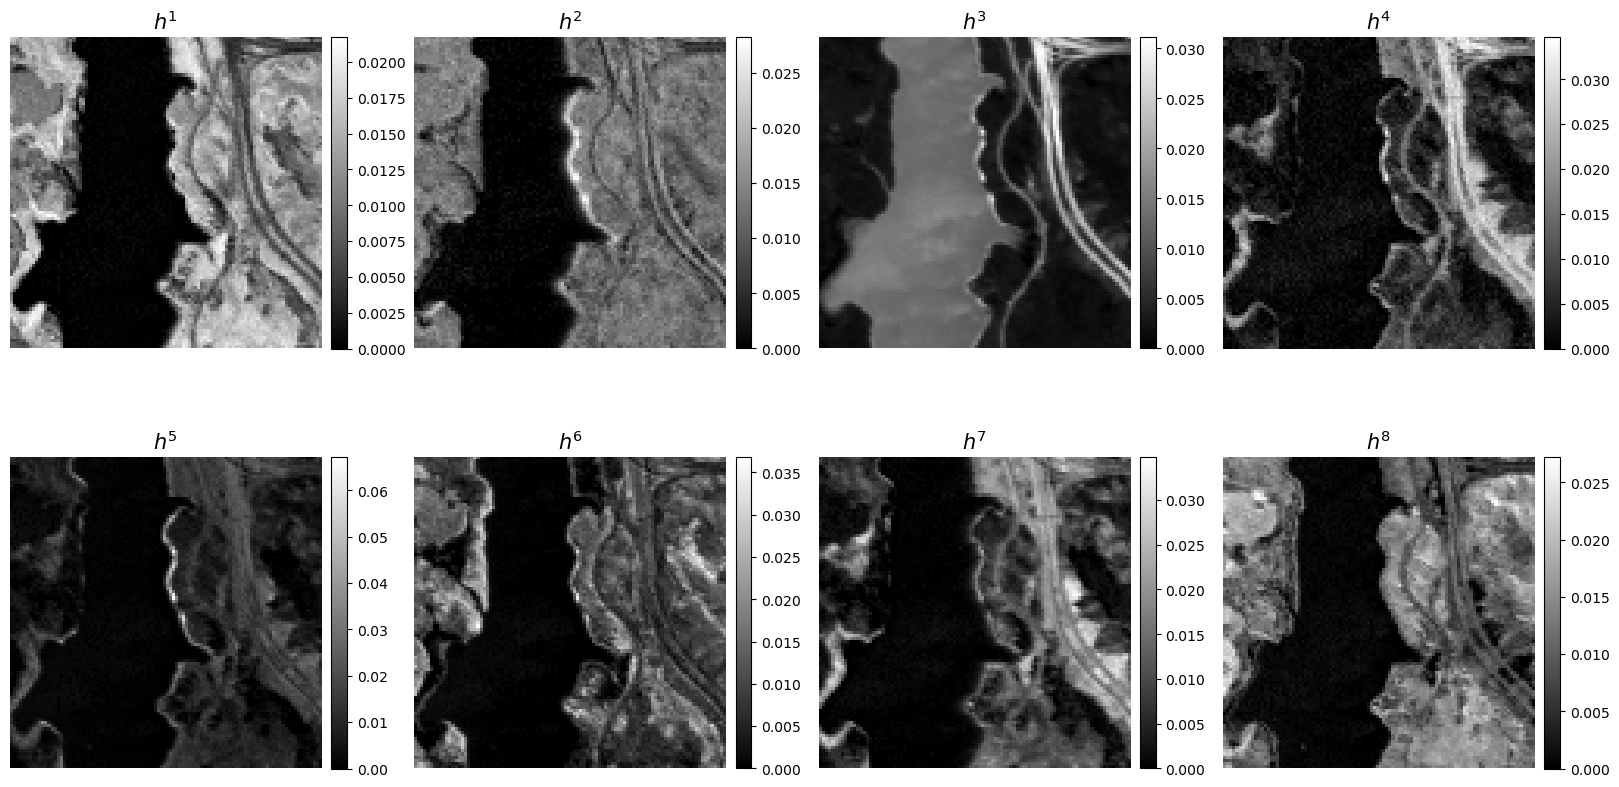

In [20]:
# model = NMF(n_components=rank, init='custom', random_state=42, tol=1e-5, max_iter=3000)
# vanillaW2 = model.fit_transform(X=X, W=ini_W.copy(), H=ini_H.copy())
# vanillaH2 = model.components_
plot_W_mats(vanillaW2, figsize=(20, 12), fontsize=15, split=True, scale_y=SCALE_Y, log_scale=LOG_SCALE, filename=img_filepath.format('w', rank, 'vanilla'))
plot_seperate_H(vanillaH2, img_size, figsize=(20, 10), fontsize=15, split=True, normalize_row=NORM_H, filename=img_filepath.format('h', rank, 'vanilla'))

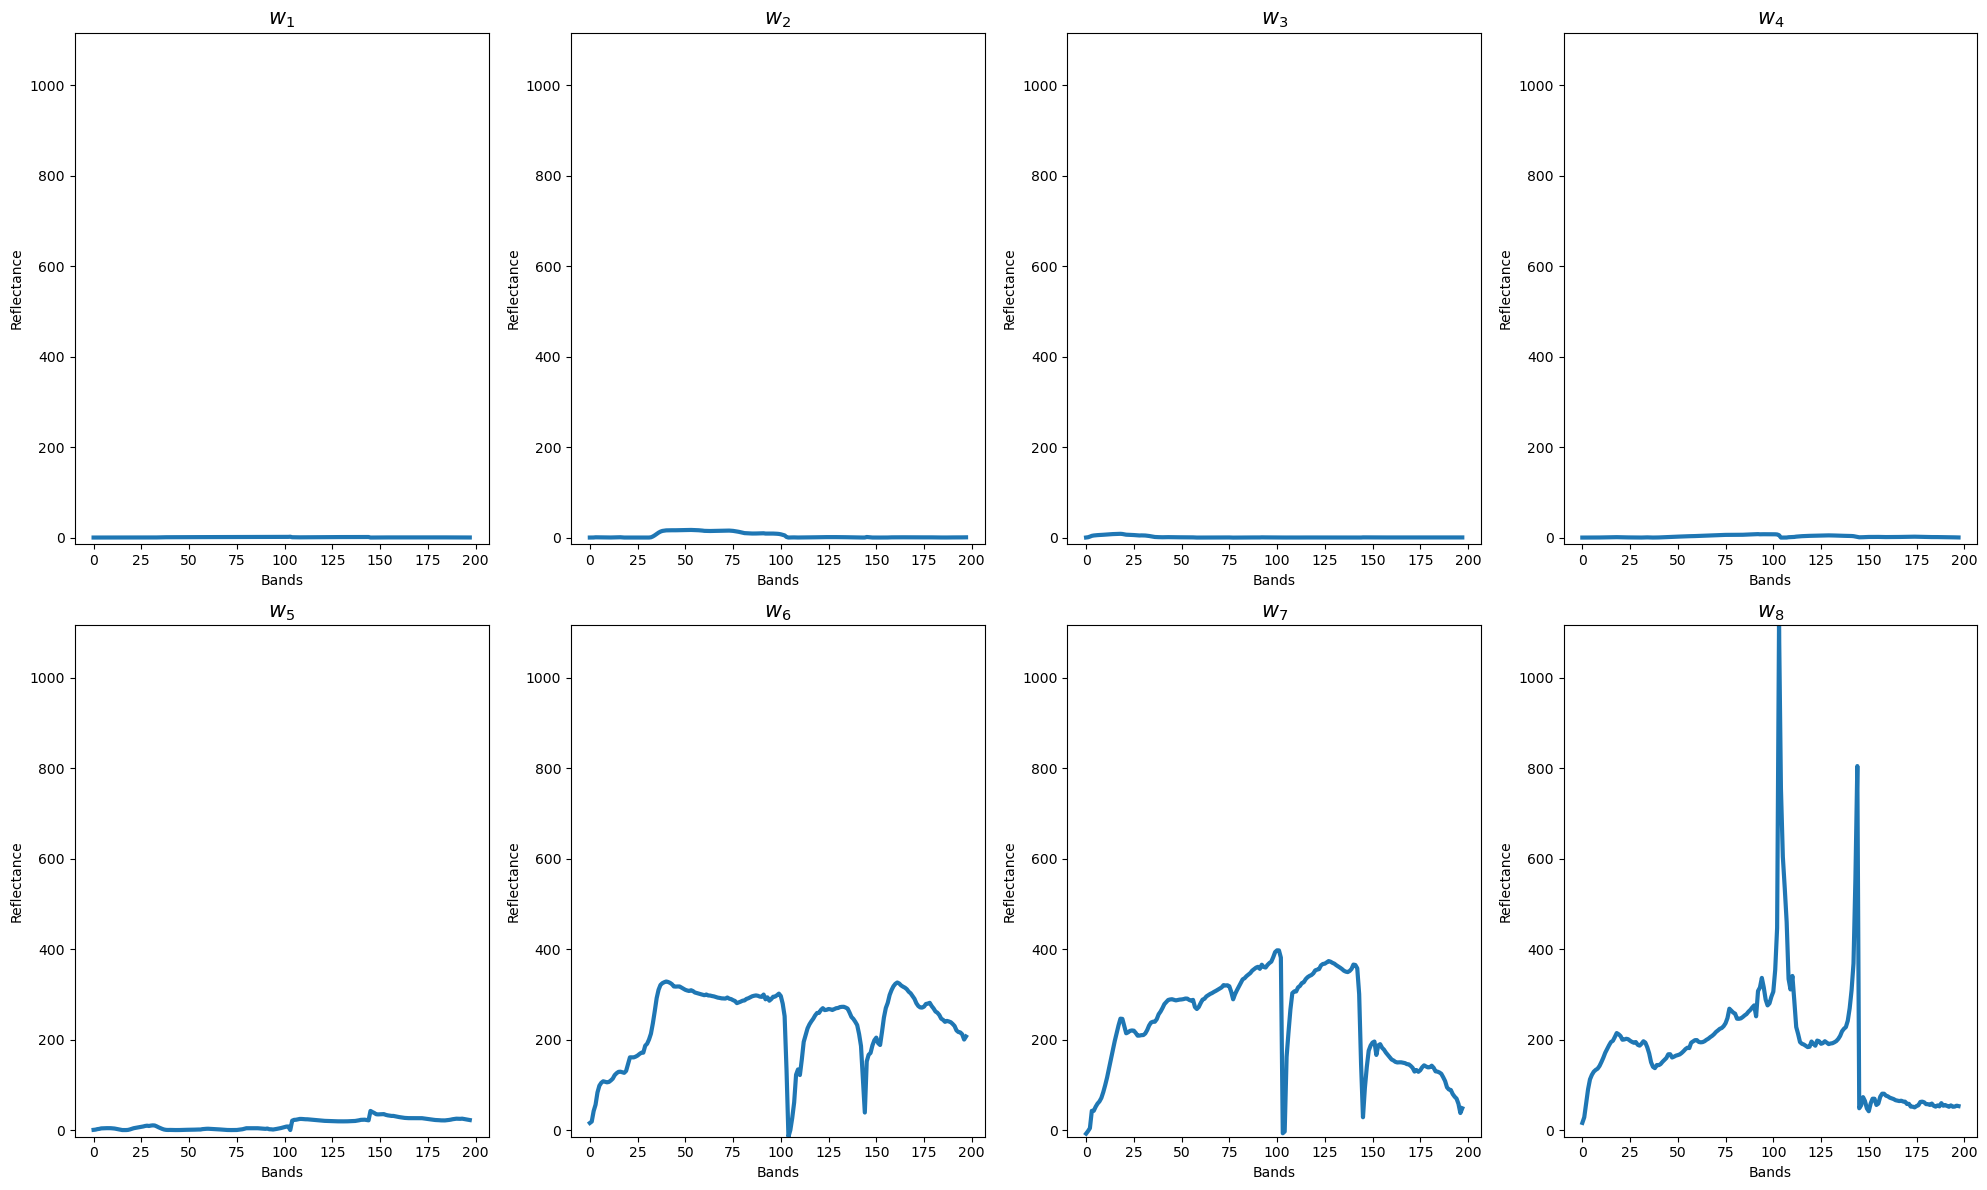

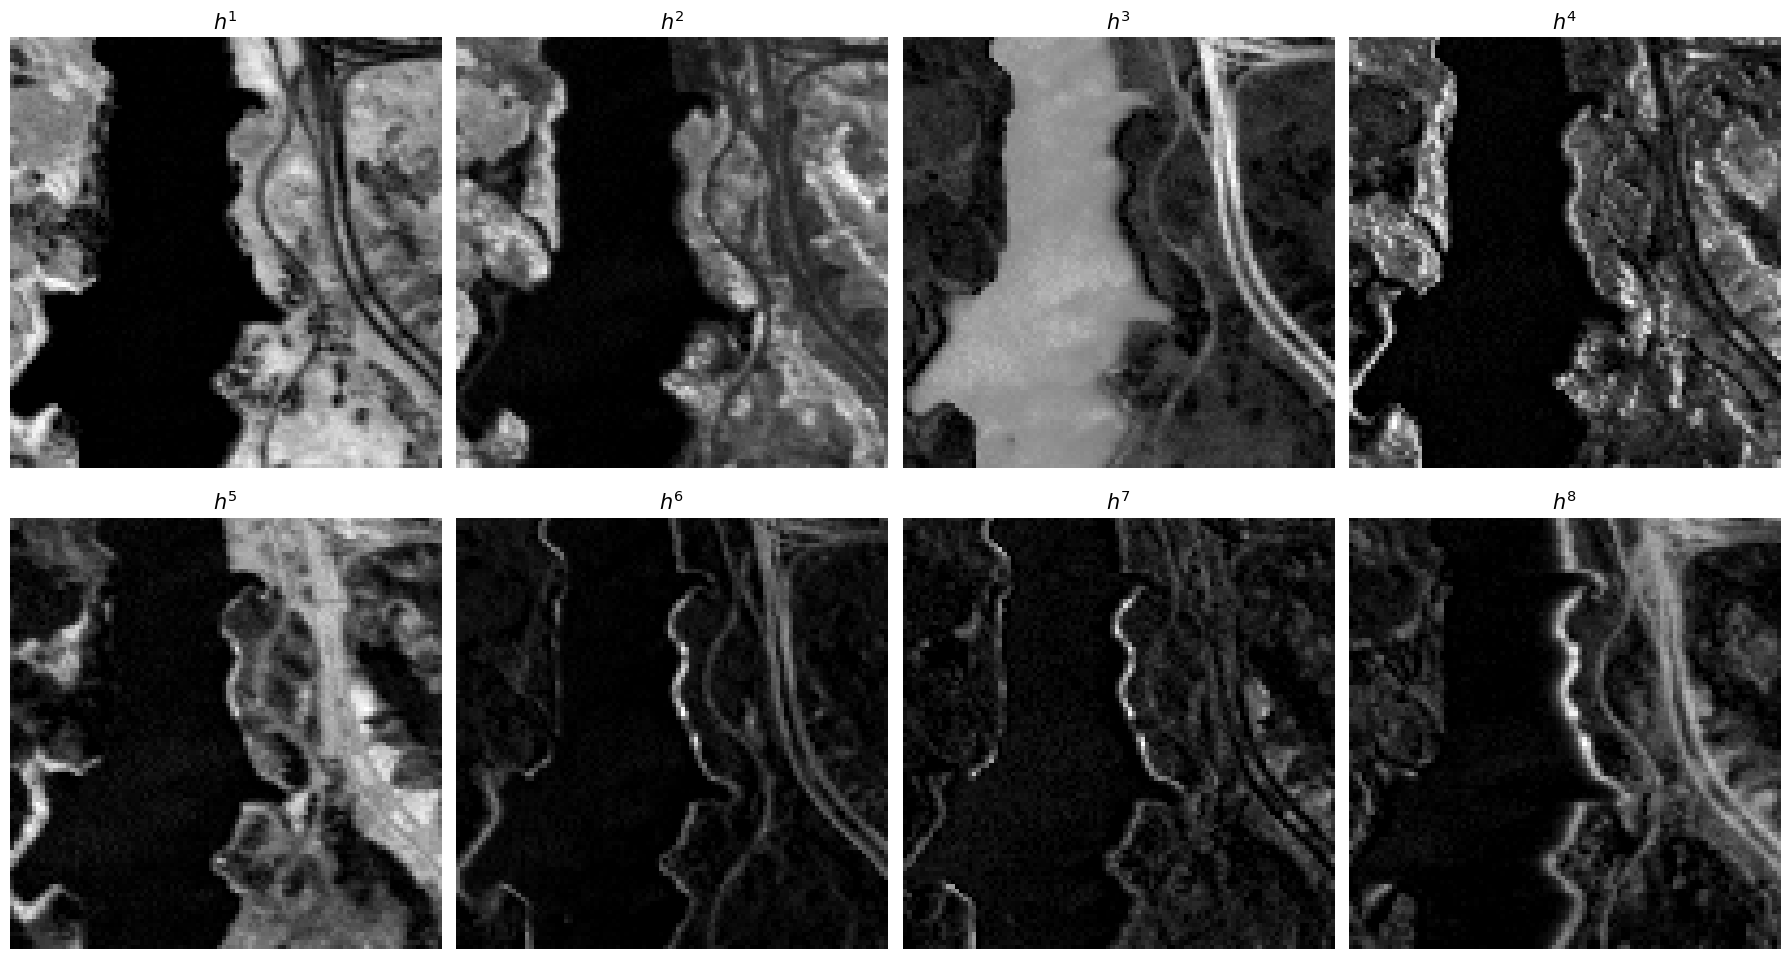

In [167]:
for reg_val in [1]:
    Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg_val))
    # plot_scores(fscores, gscores, lambda_vals, f'$\lambda = {reg_val}$')
    plot_W_mats(Wl, figsize=(20, 12), fontsize=15, split=True, scale_y=SCALE_Y, log_scale=LOG_SCALE, filename=img_filepath.format('w', rank, f'l{reg_val}'))
    plot_seperate_H(Hl, img_size, figsize=(18, 10), fontsize=15, split=True, normalize_row=NORM_H, filename=img_filepath.format('h', rank, f'l{reg_val}'))

## Small Jasper

In [ ]:
X = np.load('../datasets/jasper_small.npz')['X']
m, n = X.shape
true_rank = 3
rank = 6
img_size = (40, 40)

data = np.load(f'../saved_models/jasper_small_r6_ini.npz')
ini_W = data['W']
ini_H = data['H']

save_filepath = '../saved_models/jasper_small_tuning/r{}_l{}.npz'
img_filepath = '../images_plots/jasper_small_{}_r{}_{}.png'
# reg_vals = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
reg_vals = [1e-6, 1e-5, 0.0001, 0.001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40]

In [ ]:
# for reg_val in reg_vals:
#     Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(X, ini_W.copy(), ini_H.copy(), _lambda=reg_val, itermax=max_iter)
#     with open(save_filepath.format(rank, reg_val), 'wb') as fout:
#         np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)
#         print(reg_val, 'done')

In [ ]:
SCALE_Y = True
NORM_H = True
LOG_SCALE = False


m, n = X.shape
model = NMF(n_components=true_rank, init='random', random_state=42, tol=1e-5, max_iter=3000)
vanillaW = model.fit_transform(X=X)
vanillaH = model.components_
plot_W_mats(vanillaW, scale_y=SCALE_Y, log_scale=LOG_SCALE, filename=img_filepath.format('w', true_rank, 'vanilla'))
plot_combined_H(vanillaH, img_size, normalize_row=NORM_H, filename=img_filepath.format('h', true_rank, 'vanilla'))

In [ ]:
model = NMF(n_components=rank, init='custom', random_state=42, tol=1e-5, max_iter=3000)
vanillaW2 = model.fit_transform(X=X, W=ini_W.copy(), H=ini_H.copy())
vanillaH2 = model.components_
plot_W_mats(vanillaW2, scale_y=SCALE_Y, log_scale=LOG_SCALE, filename=img_filepath.format('w', rank, 'vanilla'))
plot_combined_H(vanillaH2, img_size, normalize_row=NORM_H, filename=img_filepath.format('h', rank, 'vanilla'))

In [ ]:
for reg_val in reg_vals[5:25]:
    Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg_val))
    # plot_scores(fscores, gscores, lambda_vals, f'$\lambda = {reg_val}$')
    plot_W_mats(Wl, scale_y=SCALE_Y, log_scale=LOG_SCALE, filename=img_filepath.format('h', rank, f'l{reg_val}'), plot_title=f'$\lambda = {reg_val}$')
    plot_combined_H(Hl, img_size, normalize_row=NORM_H, filename=img_filepath.format('h', rank, f'l{reg_val}'))

## Urban

In [ ]:
# X = np.load('../datasets/urban_full.npz')['X']
# rank = 10
# img_size = (307, 307)
# data = np.load(f'../saved_models/urban_full_r{rank}_ini.npz')
# ini_W = data['W']
# ini_H = data['H']
# save_filepath = '../saved_models/urban_tuning/r{}_l{}.npz'
#
# reg_vals = [0.01, 0.1, 1, 10, 100, 1000]

In [ ]:
# for reg_val in reg_vals:
#     Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(X, ini_W.copy(), ini_H.copy(), _lambda=reg_val, itermax=max_iter)
#     with open(save_filepath.format(rank, reg_val), 'wb') as fout:
#         np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)
#         print(reg_val, 'done')

In [ ]:
# true_rank = 6
# m, n = X.shape
# model = NMF(n_components=true_rank, init='random', random_state=42, tol=1e-5, max_iter=3000)
# vanillaW = model.fit_transform(X=X)
# vanillaH = model.components_
# plot_W_mats(vanillaW, split=True)
# plot_combined_H(vanillaH, img_size, split=True)

In [ ]:
# model = NMF(n_components=rank, init='custom', random_state=42, tol=1e-5, max_iter=3000)
# vanillaW = model.fit_transform(X=X, W=ini_W.copy(), H=ini_H.copy())
# vanillaH = model.components_
# plot_W_mats(vanillaW, split=True)
# plot_combined_H(vanillaH, img_size, split=True)

In [ ]:
# for reg_val in reg_vals:
#     Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg_val))
#     plot_scores(fscores, gscores, lambda_vals, f'$\lambda = {reg_val}$')
#     plot_W_mats(Wl, split=True)
#     plot_combined_H(Hl, img_size, split=True)